In [1]:
import numpy as np
import yaml
import pprint
from pathlib import Path
import random
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from torch.nn import MSELoss
from torch.optim import Adam
from torch import nn
import matplotlib.pyplot as plt

In [2]:
TRAIN_SET_PATH = "/opt/shared/datasets/NeoRadiumTDLdataset/train/TDLA"
EPOCHS = 10
LR = 0.0001
LIMIT_DATA_SIZE = 100000
TRAIN_SNR_LEVELS = [0, 10, 20, 30]
DEVICE = "cuda:1"

In [3]:
def calculate_mean_and_std(folder_path):
    files = list(Path(folder_path).glob("*.npy"))
    global_real_mean = 0
    global_imag_mean = 0
    global_real_std = 0
    global_imag_std = 0
    for file in files:
        file_data = np.load(file)
        real_mean = np.mean(file_data.real)
        imag_mean = np.mean(file_data.imag)
        real_std = np.std(file_data.real)
        imag_std = np.std(file_data.imag)
        global_real_mean += real_mean
        global_imag_mean += imag_mean
        global_real_std += real_std
        global_imag_std += imag_std
    global_real_mean /= len(files)
    global_imag_mean /= len(files)
    global_real_std /= len(files)
    global_imag_std /= len(files)

    stats = {
        "real_mean": global_real_mean,
        "imag_mean": global_imag_mean,
        "real_std": global_real_std,
        "imag_std": global_imag_std
    }
    return stats


In [4]:
with open(Path(TRAIN_SET_PATH, "metadata.yaml"), "r") as f:
    train_metadata = yaml.safe_load(f)
print("=== TRAIN SET METADATA ===")
pprint.pprint(train_metadata)

=== TRAIN SET METADATA ===
{'config': {'carrier_freq': '3.5e9',
            'delay_profile': 'A',
            'delay_spreads': [25,
                              50,
                              75,
                              100,
                              125,
                              150,
                              175,
                              200,
                              225,
                              250,
                              275,
                              300],
            'max_doppler_shifts': [50,
                                   100,
                                   150,
                                   200,
                                   250,
                                   300,
                                   350,
                                   400,
                                   450,
                                   500,
                                   550,
                                   600,
     

In [ ]:
class TDLDataset(Dataset):
    def __init__(
        self, data_path, *, file_size, normalization_stats=None,return_pilots_only=True, num_subcarriers=120,
        num_symbols=14, SNRs=[0, 5, 10, 15, 20, 25, 30],
        pilot_symbols=[2, 11], pilot_every_n=2):
        """
        This class loads the data from the folder and returns a dataset of channels.

        data_path: path to the folder containing the data
        file_size: number of channels per file
        return_pilots_only: if True, only the LS channel estimate at pilots are returned
            if False, the LS channel estimate is returned as a sparse channel matrix with non-zero 
            values only at the pilot subcarriers and time instants.
        num_subcarriers: number of subcarriers
        num_symbols: number of OFDM symbols

        SNRs: list of SNR values to randomly sample from when return LS estimates.
            AWGN is added to simulate LS estimatation error
        pilot_symbols: list of OFDM symbol indices where pilots are placed
        pilot_every_n: number of subcarriers between pilot subcarriers
        """
        
        self.file_size = int(file_size)
        self.normalization_stats = normalization_stats
        self.return_pilots_only = return_pilots_only
        self.num_subcarriers = num_subcarriers
        self.num_symbols = num_symbols
        self.SNRs = SNRs
        self.pilot_symbols = pilot_symbols
        self.pilot_every_n = pilot_every_n

        self.file_list = list(Path(data_path).glob("*.npy"))
        self.stats = self._get_stats_per_file(self.file_list)
        self.data = self._load_data_from_folder(self.file_list, self.normalization_stats)
        self.pilot_mask = self._get_pilot_mask()

        self.num_pilot_symbols = len(self.pilot_symbols)
        self.num_pilot_subcarriers = int(self.pilot_mask.sum()) // self.num_pilot_symbols

    def __len__(self):
        return len(self.file_list) * self.file_size

    def __getitem__(self, idx):
        file_idx = idx // self.file_size
        sample_idx = idx % self.file_size
        file_path = self.file_list[file_idx]
        channels = self.data[file_path]
        channel = channels[sample_idx].squeeze().T
    
        SNR = random.choice(self.SNRs)
        LS_channel_at_pilots = self._get_LS_estimate_at_pilots(channel, SNR)
        stats = self.stats[file_path]
        stats["SNR"] = SNR

        LS_channel_at_pilots_torch = torch.from_numpy(LS_channel_at_pilots).to(torch.complex64)
        channel_torch = torch.from_numpy(channel).to(torch.complex64)
        return LS_channel_at_pilots_torch, channel_torch, stats
    
    @staticmethod
    def _load_data_from_folder(file_list, normalization_stats=None):
        data = {}
        for file_path in file_list:
            file_data = np.load(file_path)
            if normalization_stats is not None:
                normalized_real = (file_data.real - normalization_stats["real_mean"]) / normalization_stats["real_std"]
                normalized_imag = (file_data.imag - normalization_stats["imag_mean"]) / normalization_stats["imag_std"]
                file_data = normalized_real + 1j * normalized_imag
            data[file_path] = file_data
        return data

    @staticmethod
    def _get_stats_per_file(file_list):
        stats = {}

        for file_path in file_list:
            file_name = str(file_path.stem)
            file_parts = file_name.split("_")

            if file_parts[0] == "delay":
                delay_spread = int(file_parts[2])  # [delay, spread, y, doppler, x]
                doppler_shift = int(file_parts[-1])
            elif file_parts[0] == "doppler":
                doppler_shift = int(file_parts[1])  # [doppler, x, delay, spread, y]
                delay_spread = int(file_parts[-1])
            else:
                raise ValueError(f"File {file_name} has unexpected format")
            
            if file_path not in stats:
                stats[file_path] = {"doppler_shift": doppler_shift, "delay_spread": delay_spread}
            else:
                raise ValueError(f"File {file_path} already in stats, but should not be")
            
        return stats
    
    def _get_LS_estimate_at_pilots(self, channel_matrix, SNR):
        # unit symbol power and unit channel power --> rx noise var = LS error var
        noise_std = np.sqrt(1 / (10**(SNR / 10)))
        noise_real_imag = noise_std / np.sqrt(2)

        if self.return_pilots_only:
            pilot_mask_bool = self.pilot_mask.astype(bool)
            channel_at_pilots = channel_matrix[pilot_mask_bool]
            channel_at_pilots = channel_at_pilots.reshape(self.num_pilot_subcarriers, self.num_pilot_symbols)
            noise_real = noise_real_imag * np.random.randn(self.num_pilot_subcarriers, self.num_pilot_symbols)
            noise_imag = noise_real_imag * np.random.randn(self.num_pilot_subcarriers, self.num_pilot_symbols)
            noise = noise_real + 1j * noise_imag
        else:
            channel_at_pilots = self.pilot_mask * channel_matrix
            noise_real = noise_real_imag * np.random.randn(self.num_subcarriers, self.num_symbols)
            noise_imag = noise_real_imag * np.random.randn(self.num_subcarriers, self.num_symbols)
            noise = noise_real + 1j * noise_imag
            noise = noise * self.pilot_mask
        
        channel_at_pilots_LS = channel_at_pilots + noise
            
        return channel_at_pilots_LS

    def _get_pilot_mask(self):
        pilot_mask = np.zeros((self.num_subcarriers, self.num_symbols))
        pilot_mask_subcarrier_indices = np.arange(0, self.num_subcarriers, self.pilot_every_n)
        pilot_mask[np.ix_(pilot_mask_subcarrier_indices, self.pilot_symbols)] = 1
        return pilot_mask
        

In [6]:
# simple linear model
class LinearModel(nn.Module):
    def __init__(self, num_pilot_subcarriers, num_pilot_time_inds, num_subcarriers, num_time_slots):
        super(LinearModel, self).__init__()
        self.num_pilot_subcarriers = num_pilot_subcarriers
        self.num_pilot_time_inds = num_pilot_time_inds
        self.num_subcarriers = num_subcarriers
        self.num_time_slots = num_time_slots

        input_dim = num_pilot_subcarriers * num_pilot_time_inds
        output_dim = num_subcarriers * num_time_slots
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(dim=0)  # add batch dimension if not present
        x = x.view(x.size(0), -1)
        y = self.linear(x)
        y = y.view(x.size(0), self.num_subcarriers, self.num_time_slots)
        return y


In [7]:
large_dataset = TDLDataset(
    TRAIN_SET_PATH, 
    file_size=train_metadata["config"]["num_channels_per_config"],
    SNRs=TRAIN_SNR_LEVELS,
    normalization_stats=None)  # data is already normalized to unit power 
                               # (also by the nature of TDL datasets, i.e. rayleigh fading, mean is 0 for real and imag parts)

# sample a subset of the dataset for faster training
data_indices = np.random.choice(len(large_dataset), size=LIMIT_DATA_SIZE, replace=False)
sampled_dataset = Subset(large_dataset, data_indices)

print("Dataset size:", len(sampled_dataset))
dataloader = DataLoader(sampled_dataset, batch_size=512, shuffle=True)

model = LinearModel(
    large_dataset.num_pilot_subcarriers,
    large_dataset.num_pilot_symbols,
    large_dataset.num_subcarriers,
    large_dataset.num_symbols)

device = torch.device(DEVICE)
model.to(device)

Dataset size: 100000


LinearModel(
  (linear): Linear(in_features=120, out_features=1680, bias=True)
)

In [8]:
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=LR)
losses = []

for epoch in range(EPOCHS):
    for batch in dataloader:
        h_ls, h_true, stats = batch
        h_ls = h_ls.to(device)
        h_true = h_true.to(device)
        optimizer.zero_grad()
        h_hat_real = model(h_ls.real)
        h_hat_imag = model(h_ls.imag)
        loss1 = loss_fn(h_hat_real, h_true.real)
        loss2 = loss_fn(h_hat_imag, h_true.imag)
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        pass
    print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.9569525122642517
Epoch 1, Loss: 0.9004030227661133
Epoch 2, Loss: 0.8632807731628418
Epoch 3, Loss: 0.8563980460166931
Epoch 4, Loss: 0.8416010737419128
Epoch 5, Loss: 0.8153617978096008
Epoch 6, Loss: 0.8538239002227783
Epoch 7, Loss: 0.8194180727005005
Epoch 8, Loss: 0.8242282271385193
Epoch 9, Loss: 0.8509091138839722


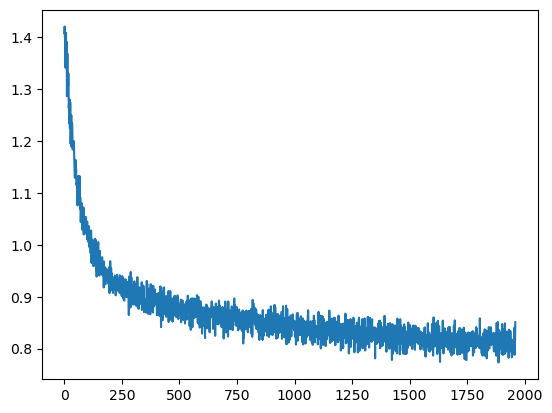

In [9]:
plt.plot(losses)
plt.show()